In [ ]:
# ---------------------------------------------------------
# CELL 1: Imports & Setup
# ---------------------------------------------------------
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray as rxr
from shapely.geometry import mapping
import os
from pathlib import Path

# Create output directories if they don't exist
os.makedirs("data/interim", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# CONFIGURATION
# 1. Update this to your chosen province name (MUST match the name in the data)
CHOSEN_PROVINCE = "Marinduque" 
# 2. Update the column name if ADM2_EN does not work. This is the province name column.
AOI_FILTER_COLUMN = 'adm2_en' 

# Define file paths using pathlib for robustness
BASE_PATH = Path('Dataset') # All data is inside the 'Dataset' folder

FILE_PATHS = {
    # Administrative Boundaries (PSGC-based shapefiles)
    'provinces': BASE_PATH / 'PSGC-based shapefiles' / 'PH_Adm2_ProvDists.shp',
    'barangays': BASE_PATH / 'PSGC-based shapefiles' / 'PH_Adm4_BgySubMuns.shp',
    
    # Facilities (HOTOSM) - CORRECTED file name: '_shp.shp'
    'facilities': BASE_PATH / 'HOTOSM Health Facilities/hotosm_phl_health_facilities_points_shp.shp',
    
    # Road Network (PBF conversion output assumption)
    # NOTE: You must run the PBF conversion step for this file to exist!
    'roads': 'data/interim/roads.gpkg',  
    
    # Flood Hazard (Placeholder - using a generic path)
    'flood': 'data/interim/flood_hazard.gpkg', 
    
    # Population Raster (WorldPop)
    'population_raster': BASE_PATH / 'WorldPop Philippines, ~100 m' / '3_pops.tif'
}

# --- CRITICAL FILE CHECK ---
print("--- VALIDATING CRITICAL FILE PATHS ---")
required_files = ['provinces', 'barangays', 'facilities', 'population_raster'] 
all_files_exist = True
for key in required_files:
    # Use Path() around the file path in case it's a string from FILE_PATHS
    file_path = Path(FILE_PATHS[key]) 
    if not file_path.exists():
        print(f"❌ MISSING FILE: {key} not found at {file_path}")
        all_files_exist = False

if not all_files_exist:
    print("\n⚠️ Please fix the paths or check your files before proceeding to CELL 2.")
else:
    print("✅ All required files found. Proceeding to load data.")
    
print(f"Project Setup Complete. Target Area: {CHOSEN_PROVINCE}")

--- VALIDATING CRITICAL FILE PATHS ---
✅ All required files found. Proceeding to load data.
Project Setup Complete. Target Area: Marinduque


In [ ]:
# ---------------------------------------------------------
# CELL 2: Load & Filter Admin Boundaries (FINAL & CORRECTED)
# ---------------------------------------------------------
print("\n--- LOADING AOI ---")
try:
    # Load Provinces (Admin Level 2). Explicitly specifying the layer avoids the UserWarning.
    gdf_prov = gpd.read_file(FILE_PATHS['provinces'], layer='PH_Adm2_ProvDists.shp') 
    
    # Filter for the chosen province using the CORRECTED lowercase column name variable
    aoi_filtered = gdf_prov[gdf_prov[AOI_FILTER_COLUMN] == CHOSEN_PROVINCE] 

    if len(aoi_filtered) == 0:
        # This will only trigger if the province name (Marinduque) is misspelled.
        raise ValueError(f"Province '{CHOSEN_PROVINCE}' not found using column '{AOI_FILTER_COLUMN}'.")

    # CRITICAL FIX: Explicitly convert the filtered result back to a GeoDataFrame 
    aoi = gpd.GeoDataFrame(aoi_filtered, geometry=aoi_filtered.geometry, crs=gdf_prov.crs)

    print(f"AOI ({CHOSEN_PROVINCE}) Loaded successfully as GeoDataFrame.")

except Exception as e:
    # If this still fails, it's likely a spelling issue in CHOSEN_PROVINCE
    print(f"\n[FATAL ERROR IN AOI LOADING] {e}")
    print("Check CHOSEN_PROVINCE spelling and the AOI_FILTER_COLUMN name.")
    # Fallback to an empty GeoDataFrame
    aoi = gpd.GeoDataFrame()


--- LOADING AOI ---
AOI (Marinduque) Loaded successfully as GeoDataFrame.


In [ ]:
# ---------------------------------------------------------
# CELL 3: Load & Clip Vector Layers (CORRECTED)
# ---------------------------------------------------------
# Check if AOI was loaded successfully before proceeding
if aoi.empty:
    print("Skipping vector loading and clipping due to AOI failure.")
    # Initialize empty GDFs to avoid errors in later cells
    gdf_brgy_clipped = gpd.GeoDataFrame()
    gdf_facilities_clipped = gpd.GeoDataFrame()
    gdf_roads_clipped = gpd.GeoDataFrame()
    gdf_flood_clipped = gpd.GeoDataFrame()
else:
    print("\n--- LOADING AND CLIPPING VECTORS ---")
    target_crs = aoi.crs # Use the native CRS (WGS84, usually EPSG:4326) for clipping

    # 1. Load Barangay Layer - ADDING EXPLICIT LAYER
    try:
        # The layer name is the same as the shapefile name
        gdf_brgy = gpd.read_file(FILE_PATHS['barangays'], layer='PH_Adm4_BgySubMuns.shp').to_crs(target_crs)
    except Exception as e:
        print(f"[FATAL ERROR] Failed to load Barangay layer: {e}")
        gdf_brgy = gpd.GeoDataFrame() # Fallback

    # 2. Load Facilities Layer (HOTOSM)
    try:
        # HOTOSM SHP files usually only have one layer, but we load it explicitly just in case.
        gdf_facilities = gpd.read_file(FILE_PATHS['facilities']).to_crs(target_crs)
    except Exception as e:
        print(f"[FATAL ERROR] Failed to load Facilities layer: {e}")
        gdf_facilities = gpd.GeoDataFrame() # Fallback
        
    # 3. Load Road Layer (load from converted file)
    try:
        gdf_roads = gpd.read_file(FILE_PATHS['roads']).to_crs(target_crs)
        print("Roads file loaded from interim folder.")
    except Exception:
        print("[WARNING] Roads file missing in interim folder. Skipping Road clipping.")
        gdf_roads = gpd.GeoDataFrame() # Empty GDF
        
    # 4. Load Flood Layer (placeholder)
    try:
        gdf_flood = gpd.read_file(FILE_PATHS['flood']).to_crs(target_crs)
        print("Flood file loaded.")
    except Exception:
        print("[WARNING] Flood hazard file missing. Skipping Flood clipping.")
        gdf_flood = gpd.GeoDataFrame() # Empty GDF

    # CLIPPING OPERATIONS - ONLY CLIP IF THE LAYER WAS LOADED SUCCESSFULLY
    
    if not gdf_brgy.empty:
        gdf_brgy_clipped = gpd.clip(gdf_brgy, aoi)
    else:
        gdf_brgy_clipped = gdf_brgy

    if not gdf_facilities.empty:
        gdf_facilities_clipped = gpd.clip(gdf_facilities, aoi)
    else:
        gdf_facilities_clipped = gdf_facilities

    if not gdf_roads.empty:
        gdf_roads_clipped = gpd.clip(gdf_roads, aoi)
    else:
        gdf_roads_clipped = gdf_roads
        
    if not gdf_flood.empty:
        gdf_flood_clipped = gpd.clip(gdf_flood, aoi)
    else:
        gdf_flood_clipped = gdf_flood
    
    print("Vector clipping complete.")


--- LOADING AND CLIPPING VECTORS ---
[WARNING] Roads file missing in interim folder. Skipping Road clipping.
[WARNING] Flood hazard file missing. Skipping Flood clipping.
Vector clipping complete.


In [ ]:
# ---------------------------------------------------------
# CELL 4: Load & Clip Raster (Population)
# ---------------------------------------------------------
print("\n--- PROCESSING RASTER ---")
try:
    pop_raster = rxr.open_rasterio(FILE_PATHS['population_raster'], masked=True)
    
    # Clip the raster using the AOI geometry
    pop_clipped = pop_raster.rio.clip(aoi.geometry.apply(mapping), aoi.crs)
    pop_clipped.rio.to_raster("data/interim/pop_clipped.tif")
    print("Raster clipped and saved successfully.")
except Exception as e:
    print(f"[ERROR] Raster clip failed. Ensure WorldPop file is accessible and AOI is loaded. Error: {e}")


--- PROCESSING RASTER ---
Raster clipped and saved successfully.


In [ ]:
# ---------------------------------------------------------
# CELL 5: Inspect Data (The Requirements)
# ---------------------------------------------------------
def inspect_layer(name, data, is_raster=False):
    # Check if layer has data before inspecting
    if not data.empty if not is_raster else data.size > 0: 
        print(f"\n--- INSPECTING: {name} ---")
        if is_raster:
            print(f"CRS: {data.rio.crs}")
            print(f"Shape: {data.shape}")
            print(f"Bounds: {data.rio.bounds()}")
            print(f"Max Value: {data.max().item():,.0f}")
        else:
            print(f"CRS: {data.crs}")
            print(f"Features (Len): {len(data)}")
            print(f"Total Bounds: {data.total_bounds}")
            print("Sample Attributes:")
            display(data.head(2))

# Run inspections
inspect_layer("Province AOI", aoi)
inspect_layer("Barangays", gdf_brgy_clipped)
inspect_layer("Facilities", gdf_facilities_clipped)
inspect_layer("Flood Hazard", gdf_flood_clipped)
inspect_layer("Roads", gdf_roads_clipped)
try:
    inspect_layer("Population Raster", pop_clipped, is_raster=True)
except NameError:
    print("\nPopulation Raster inspection skipped (pop_clipped not defined).")


--- INSPECTING: Province AOI ---
CRS: EPSG:32651
Features (Len): 1
Total Bounds: [ 370504.01094361 1458319.19770388  412144.8053329  1500534.19477821]
Sample Attributes:


,adm1_psgc,adm2_psgc,adm2_en,geo_level,len_crs,area_crs,len_km,area_km2,geometry
76,1700000000,1704000000,Marinduque,Prov,313105,922124336,313,922.0,"MULTIPOLYGON (((3.94e+05 1.46e+06, 3.94e+05 1...."



--- INSPECTING: Barangays ---
CRS: EPSG:32651
Features (Len): 218
Total Bounds: [ 370504.01094361 1458319.19770388  412144.8053329  1500534.19477821]
Sample Attributes:


,adm1_psgc,adm2_psgc,adm3_psgc,adm4_psgc,adm4_en,geo_level,len_crs,area_crs,len_km,area_km2,geometry
38035,1700000000,1704000000,1704002000,1704002013,Tungib-Lipata,Bgy,17102,11807313,17,11.0,"MULTIPOLYGON (((3.92e+05 1.46e+06, 3.92e+05 1...."
38036,1700000000,1704000000,1704002000,1704002014,Yook,Bgy,16652,8839427,16,8.0,"POLYGON ((3.94e+05 1.46e+06, 3.91e+05 1.46e+06..."



--- INSPECTING: Facilities ---
CRS: EPSG:32651
Features (Len): 18
Total Bounds: [ 373172.12551192 1472861.33874035  394920.06579878 1490156.69628809]
Sample Attributes:


,name,name_en,amenity,building,healthcare,healthca_1,operator_t,capacity_p,addr_full,addr_city,source,name_fil,osm_id,osm_type,geometry
10708,Monte's Unicare Dental Clinic,None,dentist,None,dentist,None,None,None,None,Boac,None,None,11347689975,nodes,POINT (3.75e+05 1.47e+06)
10709,Dr. Magdalena Murillo Pegris,None,dentist,None,dentist,None,None,None,None,Gasan,None,None,11347689976,nodes,POINT (3.75e+05 1.47e+06)



--- INSPECTING: Population Raster ---
CRS: EPSG:4326
Shape: (1, 457, 460)
Bounds: (121.80458286101387, 13.189583482060916, 122.18791619280239, 13.570416813877156)
Max Value: 173


C:\Users\ocana\AppData\Local\Temp\ipykernel_4704\3861259975.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left')


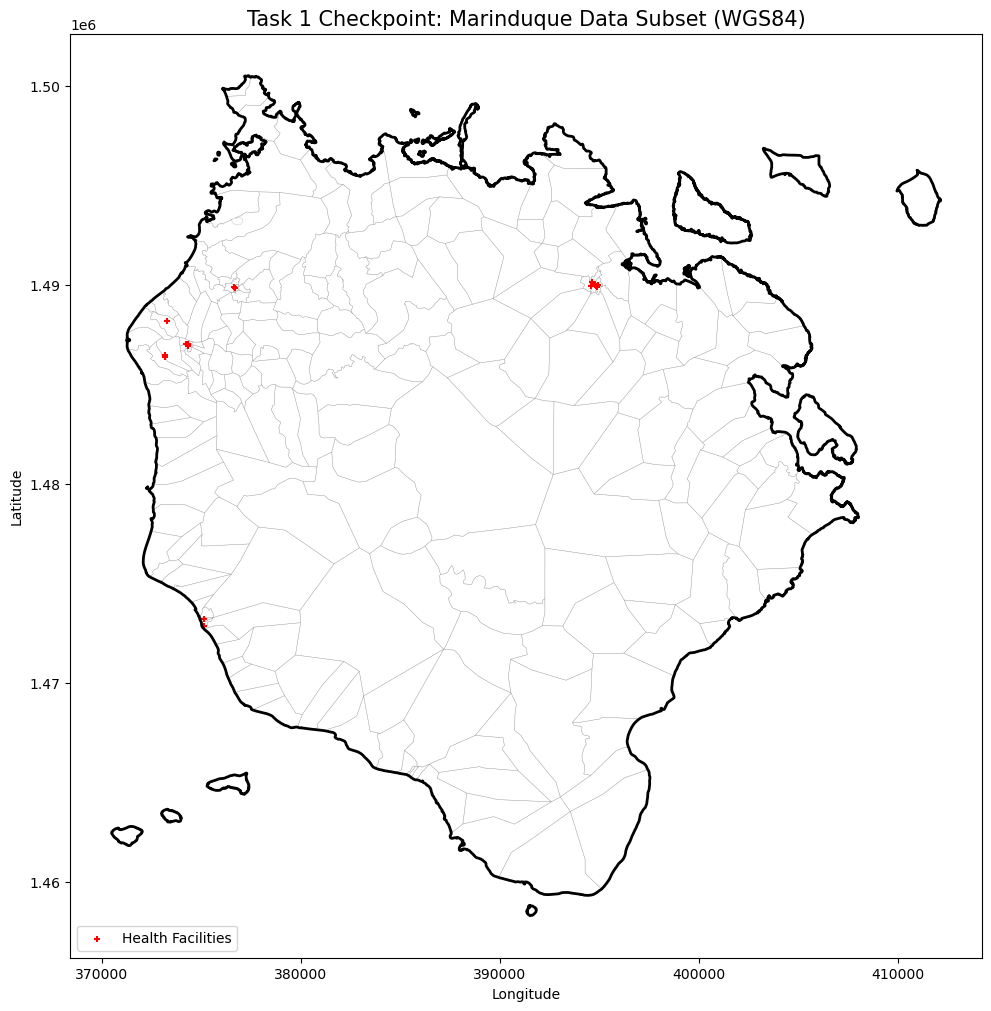

In [ ]:
# ---------------------------------------------------------
# CELL 6: Checkpoint Plot (Task 1 Output)
# ---------------------------------------------------------
if not aoi.empty and not gdf_brgy_clipped.empty:
    fig, ax = plt.subplots(figsize=(12, 12))

    # 1. Base: Province Outline
    aoi.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Province Boundary', zorder=5)

    # 2. Layer: Barangays
    gdf_brgy_clipped.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, alpha=0.5, zorder=1)

    # 3. Layer: Facilities
    gdf_facilities_clipped.plot(ax=ax, color='red', markersize=25, marker='+', label='Health Facilities', zorder=4)

    # Formatting
    ax.set_title(f"Task 1 Checkpoint: {CHOSEN_PROVINCE} Data Subset (WGS84)", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.legend(loc='lower left')

    # Save Figure
    plt.savefig("figures/01_checkpoint_map.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nSkipping Checkpoint Plot: AOI or Barangays data is empty.")

In [ ]:
# ---------------------------------------------------------
# CELL 7: Save Processed Data
# ---------------------------------------------------------
print("\nSaving interim files...")
# Save all successfully loaded/clipped GeoDataFrames
if not aoi.empty:
    aoi.to_file("data/interim/aoi.gpkg", driver="GPKG")
    gdf_brgy_clipped.to_file("data/interim/barangays.gpkg", driver="GPKG")
    gdf_facilities_clipped.to_file("data/interim/facilities.gpkg", driver="GPKG")
    
    if not gdf_roads_clipped.empty:
        gdf_roads_clipped.to_file("data/interim/roads.gpkg", driver="GPKG")
    
    if not gdf_flood_clipped.empty:
        gdf_flood_clipped.to_file("data/interim/flood.gpkg", driver="GPKG")
    
    print("All necessary vector files saved to 'data/interim'.")
else:
    print("Skipping save step as AOI was not loaded successfully.")

print("\nNotebook 01 execution complete. Ready for Notebook 02.")


Saving interim files...
All necessary vector files saved to 'data/interim'.

Notebook 01 execution complete. Ready for Notebook 02.
